# AirBnB New York: Data Classification and Predictive Model Analysis

#### Team Members: Parker Herrin, Matthew Rosenbloom, Shazia Zaman

# Overview

For this assignment, we will continue our focus on analyzing the AirBnB dataset of listings for New York City based on May 2016 data. However, because the majority of listings occur in the neighborhood group of Manhattan and based on the variables we are attempting to classify, our dataset will be modified to only view listings within Manhattan. Further duscussion and details are included throughout the assignment.

In [2]:
# Add all imports being used in the application
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from __future__ import print_function
from sklearn.cross_validation import ShuffleSplit
from sklearn import metrics as mt
from sklearn.pipeline import Pipeline
from pandas.tools.plotting import boxplot

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from IPython.html import widgets 
from sklearn import metrics as mt

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier 

from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

from sklearn.tree import DecisionTreeClassifier

warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

C:\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## 1. Data Preparation

There will essentially be three datasets that we will need to create for our analysis.
1. All Manhattan listings to be used to predict "Neighbourhood" with attributes: Neighbourhood Group, Neighbourhood, Room Type, Price, Minimum Nights, Number of Reviews, Calculated Host Listings, and Availability 365
2. All Manhattan listings to be used to predict "Price Range" with attributes: Neighbourhood Group (Manhattan only), Neighbourhood, Room Type, Price, Minimum Nights, Number of Reviews, Calculated Host Listings and Availability 365. 
3. Same dataset as above, but to include Latitude and Longitude in the dataset to see if including these as variables improves the model's accuracy.

In [3]:
# read csv file and review it
listNYC = pd.read_csv('airbnb_listings_NYC.csv', encoding = "ISO-8859-1") # read in the "listings" csv
listNYC.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,8736827,Rain or Shine Studios,45837698,Brian,Brooklyn,Sheepshead Bay,40.585989,-73.927617,Entire home/apt,2000,1,1,10/27/15,0.16,1,365
1,12270528,This is another cool listing in NYC,1667768,Martin,Manhattan,Financial District,40.704064,-74.016377,Entire home/apt,2000,1,0,NaN,NaN,2,365
2,5582283,Cozy bedroom in Brooklyn Sunsetpark,26098783,Sam,Brooklyn,Sunset Park,40.651185,-74.008421,Private room,2000,2,0,NaN,NaN,2,365
3,10549650,Prime Location Luxury Tribeca Loft,25996073,Jonathan,Manhattan,Tribeca,40.719915,-74.006409,Entire home/apt,2000,1,0,NaN,NaN,1,365
4,8515213,Studio 250 New York City,44837740,David,Manhattan,Midtown,40.755063,-73.989683,Entire home/apt,2000,1,1,1/2/16,0.25,1,351


In [4]:
#convert room type as binary variable using One-Hot encoding
room_type_enc = pd.get_dummies(listNYC['room_type'], prefix=None, prefix_sep='_', dummy_na=False, columns='room_type', sparse=False, drop_first=False)
room_type_enc.head()
listNYC = pd.concat([listNYC, room_type_enc], axis=1)
room_types = list(dict(room_type_enc.dtypes).keys())
#room_types = ['Entire home/apt', 'Private room','Shared room']

#change data type for new room types categories to integer
listNYC[room_types]=listNYC[room_types].astype(np.int64)
listNYC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32546 entries, 0 to 32545
Data columns (total 19 columns):
id                                32546 non-null int64
name                              32545 non-null object
host_id                           32546 non-null int64
host_name                         32541 non-null object
neighbourhood_group               32546 non-null object
neighbourhood                     32546 non-null object
latitude                          32546 non-null float64
longitude                         32546 non-null float64
room_type                         32546 non-null object
price                             32546 non-null int64
minimum_nights                    32546 non-null int64
number_of_reviews                 32546 non-null int64
last_review                       25076 non-null object
reviews_per_month                 25076 non-null float64
calculated_host_listings_count    32546 non-null int64
availability_365                  32546 non-null int64

In [5]:
#print some statistics
print('Some statistics about airbnb listing')
print('Price - Mean:', listNYC.price.mean(), 'Standard deviation:', listNYC.price.std())
print ('Price - Median:',listNYC.price.median())
print('Price - Min:', listNYC.price.min(), 'Max:', listNYC.price.max())

Some statistics about airbnb listing
Price - Mean: 146.97839980335525 Standard deviation: 134.84786005818793
Price - Median: 115.0
Price - Min: 10 Max: 2000


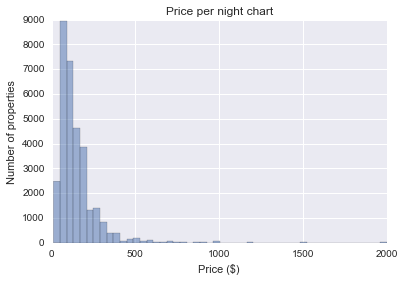

In [6]:
#create histogram for price to check normality
price_hist_plot = listNYC['price'].plot(kind='hist',alpha=0.5,bins=50)
price_hist_plot.set_title('Price per night chart')
price_hist_plot.set_xlabel('Price ($)')
price_hist_plot.set_ylabel('Number of properties')

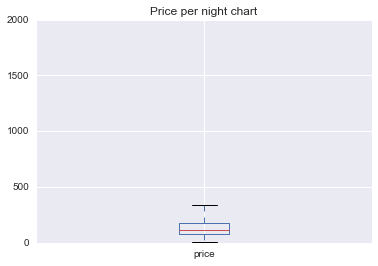

In [7]:
#create box plot for price
price_box_plot = listNYC['price'].plot(kind='box')
price_box_plot.set_title('Price per night chart')

In [8]:
#filter the dataset with price < 2000
listNYC = listNYC[listNYC.price <= 1000]
#print some statistics
print('Some statistics about airbnb listing after eliminating dataset with price > 1000')
print('Price - Mean:', listNYC.price.mean(), 'Standard deviation:', listNYC.price.std())
print ('Price - Median:',listNYC.price.median())
print('Price - Min:', listNYC.price.min(), 'Max:', listNYC.price.max())

Some statistics about airbnb listing after eliminating dataset with price > 1000
Price - Mean: 142.7644085557542 Standard deviation: 110.3670818036138
Price - Median: 113.0
Price - Min: 10 Max: 1000


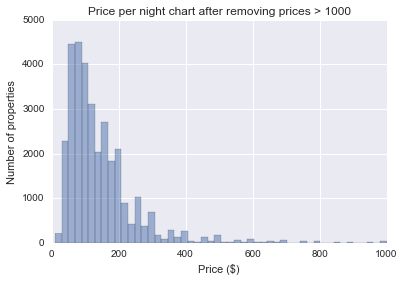

In [9]:
#create histogram for price to check normality
price_hist_plot = listNYC['price'].plot(kind='hist',alpha=0.5,bins=50)
price_hist_plot.set_title('Price per night chart after removing prices > 1000')
price_hist_plot.set_xlabel('Price ($)')
price_hist_plot.set_ylabel('Number of properties')

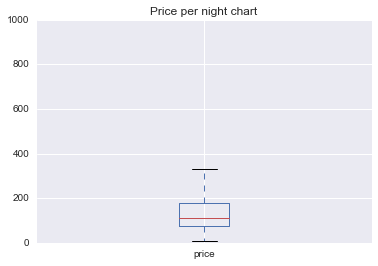

In [10]:
#create box plot for price
price_box_plot.set_title('Price per night chart after removing prices > 1000')
price_box_plot = listNYC['price'].plot(kind='box')
price_box_plot.set_title('Price per night chart')

In [11]:
#Modify listNYC to only include required attributes
listNYC_ng = listNYC[['neighbourhood_group','neighbourhood','Entire home/apt'
                      ,'Private room','Shared room','price','minimum_nights'
                      ,'number_of_reviews','calculated_host_listings_count'
                      ,'availability_365']]
listNYC_ng = listNYC_ng[(listNYC.neighbourhood_group == 'Manhattan')].copy(deep=True)
listNYC_ng.head()

,neighbourhood_group,neighbourhood,Entire home/apt,Private room,Shared room,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
102,Manhattan,Hell's Kitchen,1,0,0,1000,1,0,1,365
106,Manhattan,Gramercy,1,0,0,1000,7,0,1,365
107,Manhattan,Morningside Heights,1,0,0,1000,1,0,2,365
109,Manhattan,West Village,1,0,0,1000,3,1,1,365
110,Manhattan,East Village,1,0,0,1000,1,0,1,364


In [12]:
#print some statistics
print('Some statistics about airbnb listed as nieghbourhood group')
print('Price - Mean:', listNYC_ng.price.mean(), 'Standard deviation:', listNYC_ng.price.std())
print ('Price - Median:',listNYC_ng.price.median())
print('Price - Min:', listNYC_ng.price.min(), 'Max:', listNYC_ng.price.max())

Some statistics about airbnb listed as nieghbourhood group
Price - Mean: 171.8373712901272 Standard deviation: 123.09962722487151
Price - Median: 145.0
Price - Min: 10 Max: 1000


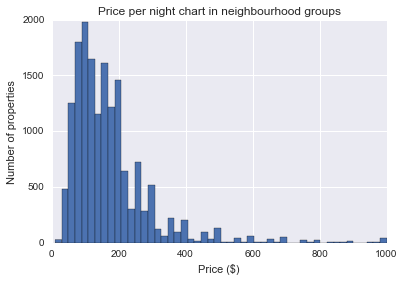

In [13]:
#create histogram for price to check normality
price_hist_plot = listNYC_ng['price'].hist(bins=50)
price_hist_plot.set_title('Price per night chart in neighbourhood groups')
price_hist_plot.set_xlabel('Price ($)')
price_hist_plot.set_ylabel('Number of properties')

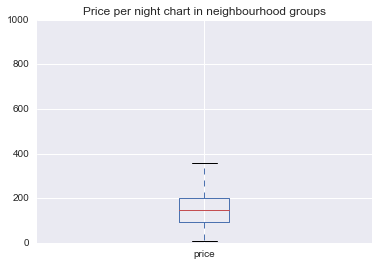

In [14]:
#create box plot for price
price_box_plot = listNYC_ng['price'].plot(kind='box')
price_box_plot.set_title('Price per night chart in neighbourhood groups')

In [15]:
#Filter data set with Manhattan neighbourhood group
listNYC_Manhattan = listNYC[(listNYC.neighbourhood_group == 'Manhattan')]
listNYC_Manhattan = listNYC_Manhattan[['neighbourhood','Entire home/apt','Private room','Shared room','price','minimum_nights','number_of_reviews','calculated_host_listings_count','availability_365']]
listNYC_Manhattan = listNYC_Manhattan.copy(deep=True)
listNYC_Manhattan.head()

,neighbourhood,Entire home/apt,Private room,Shared room,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
102,Hell's Kitchen,1,0,0,1000,1,0,1,365
106,Gramercy,1,0,0,1000,7,0,1,365
107,Morningside Heights,1,0,0,1000,1,0,2,365
109,West Village,1,0,0,1000,3,1,1,365
110,East Village,1,0,0,1000,1,0,1,364


In [16]:
#convert neighbourhoods in Manhattan as binary variable using One-Hot encoding
neighbourhood_enc = pd.get_dummies(listNYC_Manhattan['neighbourhood'], prefix=None, prefix_sep='_', dummy_na=False, columns='neighbourhood', sparse=False, drop_first=False)
neighbourhood_enc.head()

neighbourhoods = list(dict(neighbourhood_enc.dtypes).keys())

listNYC_Manhattan = pd.concat([listNYC_Manhattan, neighbourhood_enc], axis=1)

#change data type for new neighbourhood types categories to integer
listNYC_Manhattan[neighbourhoods]=listNYC_Manhattan[neighbourhoods].astype(np.int64)
#del listNYC_Manhattan['neighbourhood']
listNYC_Manhattan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16510 entries, 102 to 32545
Data columns (total 41 columns):
neighbourhood                     16510 non-null object
Entire home/apt                   16510 non-null int64
Private room                      16510 non-null int64
Shared room                       16510 non-null int64
price                             16510 non-null int64
minimum_nights                    16510 non-null int64
number_of_reviews                 16510 non-null int64
calculated_host_listings_count    16510 non-null int64
availability_365                  16510 non-null int64
Battery Park City                 16510 non-null int64
Chelsea                           16510 non-null int64
Chinatown                         16510 non-null int64
Civic Center                      16510 non-null int64
East Harlem                       16510 non-null int64
East Village                      16510 non-null int64
Financial District                16510 non-null int64
Flatiron

In [17]:
#print some records to evaluate
listNYC_Manhattan.head()

,neighbourhood,Entire home/apt,Private room,Shared room,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,Battery Park City,...,Roosevelt Island,SoHo,Stuyvesant Town,Theater District,Tribeca,Two Bridges,Upper East Side,Upper West Side,Washington Heights,West Village
102,Hell's Kitchen,1,0,0,1000,1,0,1,365,0,...,0,0,0,0,0,0,0,0,0,0
106,Gramercy,1,0,0,1000,7,0,1,365,0,...,0,0,0,0,0,0,0,0,0,0
107,Morningside Heights,1,0,0,1000,1,0,2,365,0,...,0,0,0,0,0,0,0,0,0,0
109,West Village,1,0,0,1000,3,1,1,365,0,...,0,0,0,0,0,0,0,0,0,1
110,East Village,1,0,0,1000,1,0,1,364,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
#print some statistics
listNYC_Manhattan_mean = listNYC_Manhattan.price.mean()
listNYC_Manhattan_median = listNYC_Manhattan.price.median()
listNYC_Manhattan_std = listNYC_Manhattan.price.std()
listNYC_Manhattan_min = listNYC_Manhattan.price.min()
listNYC_Manhattan_max = listNYC_Manhattan.price.max()

print('Some statistics about airbnb listing in Manhattan nieghbourhood group')
print('Price - Mean:',listNYC_Manhattan_mean , 'Standard deviation:', listNYC_Manhattan_std)
print ('Price - Median:',listNYC_Manhattan_median)
print('Price - Min:',listNYC_Manhattan_min , 'Max:', listNYC_Manhattan_max )

Some statistics about airbnb listing in Manhattan nieghbourhood group
Price - Mean: 171.8373712901272 Standard deviation: 123.09962722487151
Price - Median: 145.0
Price - Min: 10 Max: 1000


In [19]:
#create price bins for $50 incremental
bins =  [0,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000]
bin_names = ['0-49','50-99','100-149','150-199','200-249','250-299','300-349','350-399','400-449','450-499','500-549','550-599','600-649','650-699','700-749','750-799','800-849','850-899','900-949','950+']
price_range = pd.cut(listNYC_Manhattan['price'], bins, labels=bin_names)
listNYC_Manhattan['price_range'] = pd.cut(listNYC_Manhattan['price'], bins, labels=bin_names)
listNYC_Manhattan.head()

,neighbourhood,Entire home/apt,Private room,Shared room,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,Battery Park City,...,SoHo,Stuyvesant Town,Theater District,Tribeca,Two Bridges,Upper East Side,Upper West Side,Washington Heights,West Village,price_range
102,Hell's Kitchen,1,0,0,1000,1,0,1,365,0,...,0,0,0,0,0,0,0,0,0,950+
106,Gramercy,1,0,0,1000,7,0,1,365,0,...,0,0,0,0,0,0,0,0,0,950+
107,Morningside Heights,1,0,0,1000,1,0,2,365,0,...,0,0,0,0,0,0,0,0,0,950+
109,West Village,1,0,0,1000,3,1,1,365,0,...,0,0,0,0,0,0,0,0,1,950+
110,East Village,1,0,0,1000,1,0,1,364,0,...,0,0,0,0,0,0,0,0,0,950+


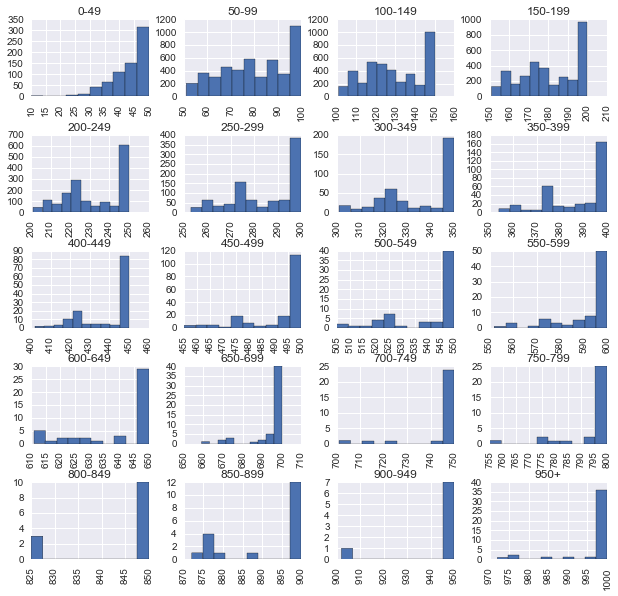

In [20]:
#create histogram for price to check normality
price_hist_plot = listNYC_Manhattan['price'].hist(by=listNYC_Manhattan['price_range'], figsize=(10,10))
#price_hist_plot.set_title('Price per night chart in Manhattan neighbourhood group')
#price_hist_plot.set_xlabel('Price ($)')
#price_hist_plot.set_ylabel('Number of properties')

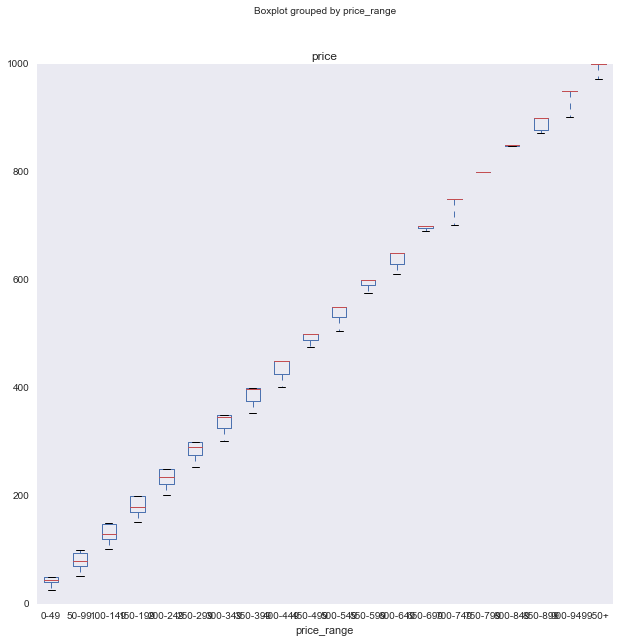

In [21]:
#create box plot for price
listNYC_Manhattan.boxplot(column='price', by='price_range', ax=None, fontsize=None, rot=0, grid=False, figsize=(10,10), layout=None, return_type=None)
#price_box_plot = listNYC_Manhattan['price'].plot(kind='box', by='price_range')
#price_box_plot.set_title('Price per night chart in Manhattan neighbourhood group')

In [22]:
#convert neighbourhoods in Manhattan as binary variable using One-Hot encoding
price_enc = pd.get_dummies(listNYC_Manhattan['price_range'], prefix=None, prefix_sep='_', dummy_na=False, columns='price_range', sparse=False, drop_first=False)
price_enc.head()

price_bins = list(dict(price_enc.dtypes).keys())

listNYC_Manhattan = pd.concat([listNYC_Manhattan, price_enc], axis=1)

#change data type for new neighbourhood types categories to integer
listNYC_Manhattan[price_bins]=listNYC_Manhattan[price_bins].astype(np.int64)
#del listNYC_Manhattan['price_range']
listNYC_Manhattan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16510 entries, 102 to 32545
Data columns (total 62 columns):
neighbourhood                     16510 non-null object
Entire home/apt                   16510 non-null int64
Private room                      16510 non-null int64
Shared room                       16510 non-null int64
price                             16510 non-null int64
minimum_nights                    16510 non-null int64
number_of_reviews                 16510 non-null int64
calculated_host_listings_count    16510 non-null int64
availability_365                  16510 non-null int64
Battery Park City                 16510 non-null int64
Chelsea                           16510 non-null int64
Chinatown                         16510 non-null int64
Civic Center                      16510 non-null int64
East Harlem                       16510 non-null int64
East Village                      16510 non-null int64
Financial District                16510 non-null int64
Flatiron

In [23]:
#print some records to evaluate
listNYC_Manhattan.head()

,neighbourhood,Entire home/apt,Private room,Shared room,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,Battery Park City,...,500-549,550-599,600-649,650-699,700-749,750-799,800-849,850-899,900-949,950+
102,Hell's Kitchen,1,0,0,1000,1,0,1,365,0,...,0,0,0,0,0,0,0,0,0,1
106,Gramercy,1,0,0,1000,7,0,1,365,0,...,0,0,0,0,0,0,0,0,0,1
107,Morningside Heights,1,0,0,1000,1,0,2,365,0,...,0,0,0,0,0,0,0,0,0,1
109,West Village,1,0,0,1000,3,1,1,365,0,...,0,0,0,0,0,0,0,0,0,1
110,East Village,1,0,0,1000,1,0,1,364,0,...,0,0,0,0,0,0,0,0,0,1


In [24]:
#Filter data set with Manhattan neighbourhood group and geo location
columns_to_model=['neighbourhood','latitude','longitude','Entire home/apt','Private room','Shared room','price','minimum_nights','number_of_reviews','calculated_host_listings_count','availability_365']
listNYC_Manhattan_geo = listNYC[(listNYC.neighbourhood_group == 'Manhattan')]
listNYC_Manhattan_geo = listNYC_Manhattan_geo[columns_to_model]
listNYC_Manhattan_geo = listNYC_Manhattan_geo.copy(deep=True)
listNYC_Manhattan_geo.head()

,neighbourhood,latitude,longitude,Entire home/apt,Private room,Shared room,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
102,Hell's Kitchen,40.759301,-73.991435,1,0,0,1000,1,0,1,365
106,Gramercy,40.736614,-73.987059,1,0,0,1000,7,0,1,365
107,Morningside Heights,40.812335,-73.957163,1,0,0,1000,1,0,2,365
109,West Village,40.735500,-73.998339,1,0,0,1000,3,1,1,365
110,East Village,40.724707,-73.985224,1,0,0,1000,1,0,1,364


In [25]:
#convert neighbourhoods in Manhattan with geo data as binary variable using One-Hot encoding
neighbourhood_enc = pd.get_dummies(listNYC_Manhattan_geo['neighbourhood'], prefix=None, prefix_sep='_', dummy_na=False, columns='neighbourhood', sparse=False, drop_first=False)
neighbourhood_enc.head()

neighbourhoods = list(dict(neighbourhood_enc.dtypes).keys())

listNYC_Manhattan_geo = pd.concat([listNYC_Manhattan_geo, neighbourhood_enc], axis=1)

#change data type for new neighbourhood types categories to integer
listNYC_Manhattan_geo[neighbourhoods]=listNYC_Manhattan_geo[neighbourhoods].astype(np.int64)
#del listNYC_Manhattan_geo['neighbourhood']
listNYC_Manhattan_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16510 entries, 102 to 32545
Data columns (total 43 columns):
neighbourhood                     16510 non-null object
latitude                          16510 non-null float64
longitude                         16510 non-null float64
Entire home/apt                   16510 non-null int64
Private room                      16510 non-null int64
Shared room                       16510 non-null int64
price                             16510 non-null int64
minimum_nights                    16510 non-null int64
number_of_reviews                 16510 non-null int64
calculated_host_listings_count    16510 non-null int64
availability_365                  16510 non-null int64
Battery Park City                 16510 non-null int64
Chelsea                           16510 non-null int64
Chinatown                         16510 non-null int64
Civic Center                      16510 non-null int64
East Harlem                       16510 non-null int64
East

In [26]:
#print some records to evaluate
listNYC_Manhattan_geo.head()

,neighbourhood,latitude,longitude,Entire home/apt,Private room,Shared room,price,minimum_nights,number_of_reviews,calculated_host_listings_count,...,Roosevelt Island,SoHo,Stuyvesant Town,Theater District,Tribeca,Two Bridges,Upper East Side,Upper West Side,Washington Heights,West Village
102,Hell's Kitchen,40.759301,-73.991435,1,0,0,1000,1,0,1,...,0,0,0,0,0,0,0,0,0,0
106,Gramercy,40.736614,-73.987059,1,0,0,1000,7,0,1,...,0,0,0,0,0,0,0,0,0,0
107,Morningside Heights,40.812335,-73.957163,1,0,0,1000,1,0,2,...,0,0,0,0,0,0,0,0,0,0
109,West Village,40.735500,-73.998339,1,0,0,1000,3,1,1,...,0,0,0,0,0,0,0,0,0,1
110,East Village,40.724707,-73.985224,1,0,0,1000,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [27]:
#print some statistics
listNYC_Manhattan_geo_mean = listNYC_Manhattan_geo.price.mean()
listNYC_Manhattan_geo_median = listNYC_Manhattan_geo.price.median()
listNYC_Manhattan_geo_std = listNYC_Manhattan_geo.price.std()
listNYC_Manhattan_geo_min = listNYC_Manhattan_geo.price.min()
listNYC_Manhattan_geo_max = listNYC_Manhattan_geo.price.max()

print('Some statistics about airbnb listing in Manhattan nieghbourhood group with geo data')
print('Price - Mean:',listNYC_Manhattan_geo_mean , 'Standard deviation:', listNYC_Manhattan_geo_std)
print ('Price - Median:',listNYC_Manhattan_geo_median)
print('Price - Min:',listNYC_Manhattan_geo_min , 'Max:', listNYC_Manhattan_geo_max )

#normalize price data

Some statistics about airbnb listing in Manhattan nieghbourhood group with geo data
Price - Mean: 171.8373712901272 Standard deviation: 123.09962722487151
Price - Median: 145.0
Price - Min: 10 Max: 1000


In [28]:
#print some statistics
listNYC_Manhattan_geo_mean = listNYC_Manhattan_geo.price.mean()
listNYC_Manhattan_geo_median = listNYC_Manhattan_geo.price.median()
listNYC_Manhattan_geo_std = listNYC_Manhattan_geo.price.std()
listNYC_Manhattan_geo_min = listNYC_Manhattan_geo.price.min()
listNYC_Manhattan_geo_max = listNYC_Manhattan_geo.price.max()

print('Some statistics about airbnb listing in Manhattan nieghbourhood group with geo data')
print('Price - Mean:',listNYC_Manhattan_geo_mean , 'Standard deviation:', listNYC_Manhattan_geo_std)
print ('Price - Median:',listNYC_Manhattan_geo_median)
print('Price - Min:',listNYC_Manhattan_geo_min , 'Max:', listNYC_Manhattan_geo_max )

#normalize price data

Some statistics about airbnb listing in Manhattan nieghbourhood group with geo data
Price - Mean: 171.8373712901272 Standard deviation: 123.09962722487151
Price - Median: 145.0
Price - Min: 10 Max: 1000


In [29]:
#create price bins for $50 incremental
bins =  [0,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000]
bin_names = ['0-49','50-99','100-149','150-199','200-249','250-299','300-349','350-399','400-449','450-499','500-549','550-599','600-649','650-699','700-749','750-799','800-849','850-899','900-949','950+']
price_range = pd.cut(listNYC_Manhattan_geo['price'], bins, labels=bin_names)
listNYC_Manhattan_geo['price_range'] = pd.cut(listNYC_Manhattan_geo['price'], bins, labels=bin_names)
listNYC_Manhattan_geo.head()

,neighbourhood,latitude,longitude,Entire home/apt,Private room,Shared room,price,minimum_nights,number_of_reviews,calculated_host_listings_count,...,SoHo,Stuyvesant Town,Theater District,Tribeca,Two Bridges,Upper East Side,Upper West Side,Washington Heights,West Village,price_range
102,Hell's Kitchen,40.759301,-73.991435,1,0,0,1000,1,0,1,...,0,0,0,0,0,0,0,0,0,950+
106,Gramercy,40.736614,-73.987059,1,0,0,1000,7,0,1,...,0,0,0,0,0,0,0,0,0,950+
107,Morningside Heights,40.812335,-73.957163,1,0,0,1000,1,0,2,...,0,0,0,0,0,0,0,0,0,950+
109,West Village,40.735500,-73.998339,1,0,0,1000,3,1,1,...,0,0,0,0,0,0,0,0,1,950+
110,East Village,40.724707,-73.985224,1,0,0,1000,1,0,1,...,0,0,0,0,0,0,0,0,0,950+


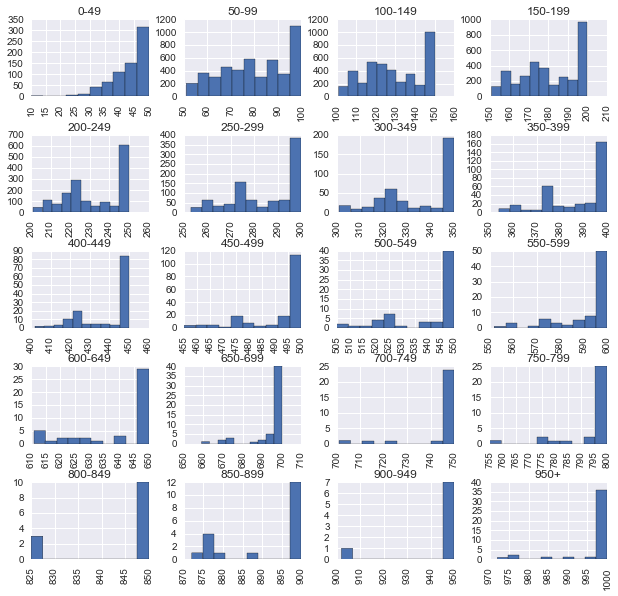

In [30]:
#create histogram for price to check normality
price_hist_plot = listNYC_Manhattan_geo['price'].hist(by=listNYC_Manhattan_geo['price_range'], figsize=(10,10))
#price_hist_plot.set_title('Price per night chart in Manhattan geo location')
#price_hist_plot.set_xlabel('Price ($)')
#price_hist_plot.set_ylabel('Number of properties')

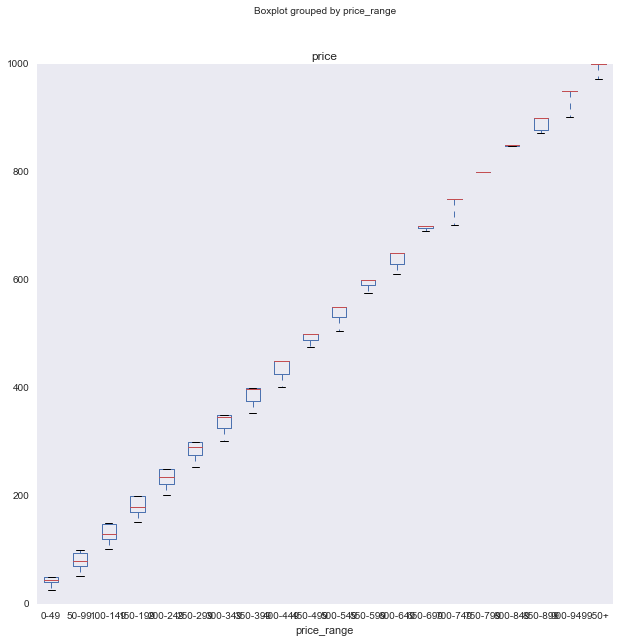

In [31]:
#create box plot for price
listNYC_Manhattan_geo.boxplot(column='price', by='price_range', ax=None, fontsize=None, rot=0, grid=False, figsize=(10,10), layout=None, return_type=None)
#price_box_plot = listNYC_Manhattan_geo['price'].plot(kind='box')
#price_box_plot.set_title('Price per night chart in Manhattan geo location')

In [32]:
#convert neighbourhoods in Manhattan as binary variable using One-Hot encoding
price_enc = pd.get_dummies(listNYC_Manhattan_geo['price_range'], prefix=None, prefix_sep='_', dummy_na=False, columns='price_range', sparse=False, drop_first=False)
price_enc.head()

price_bins = list(dict(price_enc.dtypes).keys())

listNYC_Manhattan_geo = pd.concat([listNYC_Manhattan_geo, price_enc], axis=1)

#change data type for new neighbourhood types categories to integer
listNYC_Manhattan_geo[price_bins]=listNYC_Manhattan_geo[price_bins].astype(np.int64)
#del listNYC_Manhattan['price_range']
listNYC_Manhattan_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16510 entries, 102 to 32545
Data columns (total 64 columns):
neighbourhood                     16510 non-null object
latitude                          16510 non-null float64
longitude                         16510 non-null float64
Entire home/apt                   16510 non-null int64
Private room                      16510 non-null int64
Shared room                       16510 non-null int64
price                             16510 non-null int64
minimum_nights                    16510 non-null int64
number_of_reviews                 16510 non-null int64
calculated_host_listings_count    16510 non-null int64
availability_365                  16510 non-null int64
Battery Park City                 16510 non-null int64
Chelsea                           16510 non-null int64
Chinatown                         16510 non-null int64
Civic Center                      16510 non-null int64
East Harlem                       16510 non-null int64
East

In [33]:
#print some records to evaluate
listNYC_Manhattan_geo.head()

,neighbourhood,latitude,longitude,Entire home/apt,Private room,Shared room,price,minimum_nights,number_of_reviews,calculated_host_listings_count,...,500-549,550-599,600-649,650-699,700-749,750-799,800-849,850-899,900-949,950+
102,Hell's Kitchen,40.759301,-73.991435,1,0,0,1000,1,0,1,...,0,0,0,0,0,0,0,0,0,1
106,Gramercy,40.736614,-73.987059,1,0,0,1000,7,0,1,...,0,0,0,0,0,0,0,0,0,1
107,Morningside Heights,40.812335,-73.957163,1,0,0,1000,1,0,2,...,0,0,0,0,0,0,0,0,0,1
109,West Village,40.735500,-73.998339,1,0,0,1000,3,1,1,...,0,0,0,0,0,0,0,0,0,1
110,East Village,40.724707,-73.985224,1,0,0,1000,1,0,1,...,0,0,0,0,0,0,0,0,0,1


## 2. Modeling and Evaluation

### 2a. Choose and explain the evalution metrics chosen

For this analysis and the models selected, the primary evaluation metric we will be focusing on is Accuracy. Due to the variables we have chosen to predict (Neighborhood and Price Range), the accuracy metric provides us with the most easily interpreted metric to gauge the success (or failure) of the models used. Accuracy will be able to essentially tell us the percentage of correctly guessed classifications over the total number of possible classifications in both cases. 

Because of the number of classes we are trying to predict for each predictive attribute, we can easily tell at the surface level how often are model is accurately predicting either the price level or the neighbourhood. If we wish to continue to improve the results of our models, we can also include binary confusion matrices to se where the errors are occuring and to further analyze which listings were causing the errors, make detailed notes about those listings, and possibly take those inferences into consideration when attempting to modify the model.

### 2b. Choose the method(s) used to divide data into training and testing splits

For this assignment, we will be using a cross-validation technique in order to train and test our data with. More specifically, we will be using the "Stratified Shuffle Split" function via Scikit Learn to perform this task. This process was used in our previous assignment and realized it worked relatively well for the type of dataset we are using. We intend to run a minimum of five iterations of the test (per model) using 80% of the data each time for training the model and the remaining 20% to be used to test the trained data on. 

### 2c. Create three different classification models for each task

#### Setting attributes list in order to use in models

In [34]:
#get all column names to include in model as response and explanatory attributes
attributes_price_range = list(listNYC_Manhattan.price_range.unique())
attributes_neighbourhoods = list(listNYC_Manhattan.neighbourhood.unique())
attributes_room_type = room_types
attributes_geo = ['latitude','longitude']
#print('price range attributes:', attributes_price_range)
#print('neighbourhood attributes:', attributes_neighbourhoods)
#print('room type attributes:', attributes_room_type)
actual_attributes = ['minimum_nights'
                 ,'number_of_reviews','calculated_host_listings_count'
                 ,'availability_365']

### FIRST PREDICTION: Price Range of AirBnB Listing

#### Setting up training and test data for Price prediction

In [35]:
# create train and test sets for listNYC_Manhattan to predict price range
exp_attributes_pr = attributes_neighbourhoods + attributes_room_type + actual_attributes

listNYC_Manhattan.target_pr = listNYC_Manhattan[attributes_price_range].values
listNYC_Manhattan.data_pr = listNYC_Manhattan[exp_attributes_pr].values
listNYC_Manhattan_pr_cv = StratifiedShuffleSplit(listNYC_Manhattan.target_pr
                                              , n_iter = 5
                                              , test_size = 0.2
                                              , train_size=0.8)
print('cv:',listNYC_Manhattan_pr_cv)

for trainidx, testidx in listNYC_Manhattan_pr_cv:
    # note that these are sparse matrices
    X_pr_train = listNYC_Manhattan.data_pr[trainidx] 
    X_pr_test = listNYC_Manhattan.data_pr[testidx] 
    y_pr_train = listNYC_Manhattan.target_pr[trainidx]
    y_pr_test = listNYC_Manhattan.target_pr[testidx]

X_pr = listNYC_Manhattan.data_pr
y_pr = listNYC_Manhattan.target_pr
yhat_pr = np.zeros(y_pr.shape)


cv: StratifiedShuffleSplit(labels=[[1 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]], n_iter=5, test_size=0.2, random_state=None)


#### Price range prediction using KNN

In [36]:
# calculate accuracy for price range prediction using KNN
K = 5 
clf_pr = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean')

for train, test in listNYC_Manhattan_pr_cv:
    clf_pr.fit(X_pr[train],y_pr[train])
    yhat_pr[test] = clf_pr.predict(X_pr[test])
        
acc_clf_pr = mt.accuracy_score(y_pr, yhat_pr)

print ('accuracy:',acc_clf_pr)
print('Accuracy of classifier to predict price range with %d neighbors with K=5 is: %.2f'%(K,acc_clf_pr))

accuracy: 0.882556026651
Accuracy of classifier to predict price range with 5 neighbors with K=5 is: 0.88


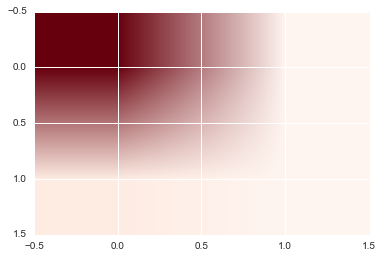

In [70]:
#Confusion metrics representation for price range 50-99
cm = mt.confusion_matrix(y_pr[1], yhat_pr[1])
cm
plt.imshow(cm,cmap=plt.get_cmap('Reds'),aspect='auto')

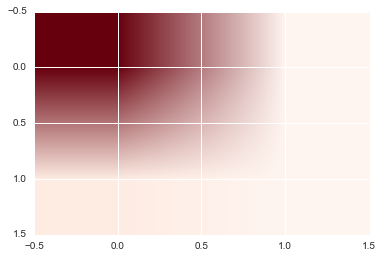

In [69]:
#Confusion metrics representation for price range 100-149
cm = mt.confusion_matrix(y_pr[2], yhat_pr[2])
cm
plt.imshow(cm,cmap=plt.get_cmap('Reds'),aspect='auto')

In [66]:
#calculate K Nearest Neighbours graph

#### Price range prediction using Random Forest

In [38]:
# calculate accuracy for price range prediction using Random Forest
forest_pr = RandomForestClassifier(n_estimators = 10)

for train, test in listNYC_Manhattan_pr_cv:
    forest_pr.fit(X_pr[train],y_pr[train])
    yhat_pr[test] = forest_pr.predict(X_pr[test])
    
acc_forest_pr= mt.accuracy_score(y_pr, yhat_pr)
print('accuracy for price range prediction with RandomForest: ', acc_forest_pr)

accuracy for price range prediction with RandomForest:  0.8841308298


In [39]:
#calculate feature importance for price predictions from Random Forest
feature_imp_pr = forest_pr.feature_importances_
attribute_names = listNYC_Manhattan[exp_attributes_pr].columns
for feature_imp, name in zip(feature_imp_pr,attribute_names):
    print(name, 'has feature importance of', feature_imp)

Hell's Kitchen has feature importance of 0.00786967328657
Gramercy has feature importance of 0.00389851833399
Morningside Heights has feature importance of 0.00365580398237
West Village has feature importance of 0.00510047721102
East Village has feature importance of 0.00562520469098
Midtown has feature importance of 0.00542654168687
SoHo has feature importance of 0.00376075021538
Chelsea has feature importance of 0.00475478645572
Flatiron District has feature importance of 0.00247161448566
Harlem has feature importance of 0.0122594976067
Tribeca has feature importance of 0.00296292651647
Upper West Side has feature importance of 0.00751702016937
Upper East Side has feature importance of 0.00570293320227
Financial District has feature importance of 0.00396097827511
Greenwich Village has feature importance of 0.00354393590463
Kips Bay has feature importance of 0.00432773904931
Theater District has feature importance of 0.00271952631594
Nolita has feature importance of 0.00405368881235
N

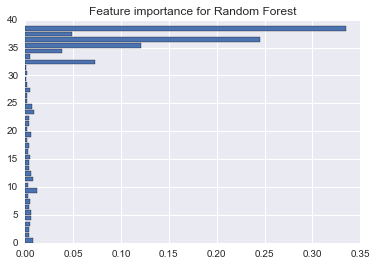

In [40]:
#show graph for feature importance for Random Forest 
plt.barh(range(len(feature_imp_pr)), feature_imp_pr)
plt.title("Feature importance for Random Forest")
plt.show()

#### Price range prediction using Decision Trees

In [41]:
# calculate accuracy for price range prediction using Decision Trees:
dt_pr = DecisionTreeClassifier(criterion='entropy', max_depth=10, 
                                min_samples_split=500, min_samples_leaf=1, 
                                max_leaf_nodes=None)

for train, test in listNYC_Manhattan_pr_cv:
    dt_pr.fit(X_pr[train],y_pr[train])
    yhat_pr[test] = dt_pr.predict(X_pr[test])
    
acc_dt_pr= mt.accuracy_score(y_pr, yhat_pr)
print('accuracy for price range prediction with Decision Tree: ', acc_dt_pr)

accuracy for price range prediction with Decision Tree:  0.264142943671


In [42]:
#calculate feature importance for price predictions from Random Forest
feature_imp_pr_dt = dt_pr.feature_importances_
attribute_names = listNYC_Manhattan[exp_attributes_pr].columns
for feature_imp, name in zip(feature_imp_pr_dt,attribute_names):
    print(name, 'has feature importance of', feature_imp)

Hell's Kitchen has feature importance of 0.0
Gramercy has feature importance of 0.000450251493165
Morningside Heights has feature importance of 0.0136591619045
West Village has feature importance of 0.00111271363398
East Village has feature importance of 0.00403650846613
Midtown has feature importance of 0.00289043385387
SoHo has feature importance of 0.000573140663981
Chelsea has feature importance of 0.0
Flatiron District has feature importance of 0.0
Harlem has feature importance of 0.0490369060561
Tribeca has feature importance of 0.00143057741177
Upper West Side has feature importance of 0.00318779332405
Upper East Side has feature importance of 0.0113073485306
Financial District has feature importance of 0.000891447426044
Greenwich Village has feature importance of 0.0
Kips Bay has feature importance of 0.000778057878326
Theater District has feature importance of 0.0
Nolita has feature importance of 0.0
NoHo has feature importance of 0.0
Lower East Side has feature importance of 

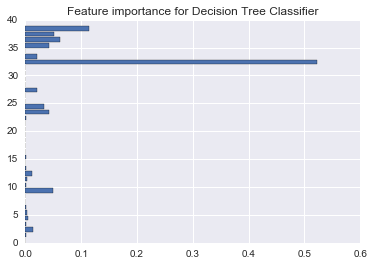

In [43]:
#show graph for feature importance for Decision Tree Classifier 
plt.barh(range(len(feature_imp_pr_dt)), feature_imp_pr_dt)
plt.title("Feature importance for Decision Tree Classifier")
plt.show()

### SECOND PREDICTION: Manhattan "Neighbourhood" of AirBnB Listing

#### Setting up training and test data for neighbourhood prediction

In [44]:
# create train and test sets for listNYC_Manhattan to predict neighbourhood
exp_attributes_ng = attributes_price_range + attributes_room_type + actual_attributes

listNYC_Manhattan.target_ng = listNYC_Manhattan[attributes_neighbourhoods].values
listNYC_Manhattan.data_ng = listNYC_Manhattan[exp_attributes_ng].values
listNYC_Manhattan_ng_cv = StratifiedShuffleSplit(listNYC_Manhattan.target_ng
                                              , n_iter = 5
                                              , test_size = 0.2
                                              , train_size=0.8)

print('cv:',listNYC_Manhattan_ng_cv)

for trainidx, testidx in listNYC_Manhattan_ng_cv:
    X_ng_train = listNYC_Manhattan.data_ng[trainidx] 
    X_ng_test = listNYC_Manhattan.data_ng[testidx] 
    y_ng_train = listNYC_Manhattan.target_ng[trainidx]
    y_ng_test = listNYC_Manhattan.target_ng[testidx]

X_ng = listNYC_Manhattan.data_ng
y_ng = listNYC_Manhattan.target_ng
yhat_ng = np.zeros(y_ng.shape)

cv: StratifiedShuffleSplit(labels=[[1 0 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 0 1 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]], n_iter=5, test_size=0.2, random_state=None)


#### Neighbourhood prediction using KNN

In [45]:
# calculate accuracy for neighbourhood prediction using KNN
K = 5 
clf_ng = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean')

for train, test in listNYC_Manhattan_ng_cv:
    clf_ng.fit(X_ng[train],y_ng[train])
    yhat_ng[test] = clf_ng.predict(X_ng[test])
    
acc_clf_ng = mt.accuracy_score(y_ng, yhat_ng)

print ('accuracy:',acc_clf_ng)
print('Accuracy of classifier to predict neighbourhood with %d neighbors with K=5 is: %.2f'%(K,acc_clf_ng))

accuracy: 0.786856450636
Accuracy of classifier to predict neighbourhood with 5 neighbors with K=5 is: 0.79


In [46]:
#calculate weights for neighbourhood predictions from K Neighbourhood Classifier

#### Neighbourhood prediction using Random Forest

In [47]:
# calculate accuracy for neighbourhood prediction using Random Forest
forest_ng = RandomForestClassifier(n_estimators = 10)

for train, test in listNYC_Manhattan_ng_cv:
    forest_ng.fit(X_ng[train],y_ng[train])
    yhat_ng[test] = forest_ng.predict(X_ng[test])
    
acc_ng= mt.accuracy_score(y_ng, yhat_ng)
print('accuracy for neighbourhood prediction with RandomForest: ', acc_ng)

accuracy for neighbourhood prediction with RandomForest:  0.775953967293


In [48]:
#calculate feature importance for neighbourhood predictions from Random Forest
feature_imp_ng = forest_ng.feature_importances_ 
attribute_names = listNYC_Manhattan[exp_attributes_ng].columns
for feature_imp, name in zip(feature_imp_ng, attribute_names):
    print(name, 'has feature importance of', feature_imp)

950+ has feature importance of 0.000702527859848
900-949 has feature importance of 0.000322922925937
850-899 has feature importance of 0.000542611019414
800-849 has feature importance of 0.000507926280376
750-799 has feature importance of 0.000743320282023
700-749 has feature importance of 0.000748788135728
650-699 has feature importance of 0.00113234561187
600-649 has feature importance of 0.00109764759876
550-599 has feature importance of 0.00145428608038
500-549 has feature importance of 0.00140115668075
450-499 has feature importance of 0.0014992242366
400-449 has feature importance of 0.00188411377802
350-399 has feature importance of 0.00195493660193
300-349 has feature importance of 0.00210396224412
250-299 has feature importance of 0.00243053426127
200-249 has feature importance of 0.00306363179686
150-199 has feature importance of 0.00284193494514
100-149 has feature importance of 0.00401222339732
50-99 has feature importance of 0.00651592277957
0-49 has feature importance of 

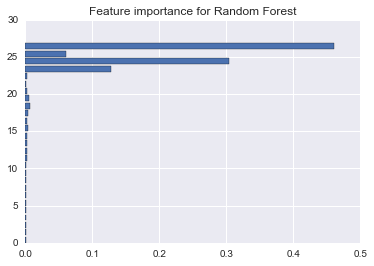

In [49]:
#show graph for feature importance for Random Forest 
plt.barh(range(len(feature_imp_ng)), feature_imp_ng)
plt.title("Feature importance for Random Forest")
plt.show()

#### Neighbourhood prediction using Decision Tree

In [52]:
# calculate accuracy for neighbourhood prediction using Decision Trees:
dt_ng = DecisionTreeClassifier(criterion='gini', max_depth=None, 
                                min_samples_split=2, min_samples_leaf=1, 
                                max_features=None, 
                                max_leaf_nodes=None)

for train, test in listNYC_Manhattan_ng_cv:
    dt_ng.fit(X_ng[train],y_ng[train])
    yhat_ng[test] = dt_ng.predict(X_ng[test])
    
acc_dt_ng= mt.accuracy_score(y_ng, yhat_ng)
print('accuracy for price range prediction with Decision Tree: ', acc_dt_ng)

accuracy for price range prediction with Decision Tree:  0.772864930345


In [53]:
#calculate feature importance for price predictions from Random Forest
feature_imp_ng_dt = dt_ng.feature_importances_
attribute_names = listNYC_Manhattan[exp_attributes_ng].columns
for feature_imp, name in zip(feature_imp_ng_dt,attribute_names):
    print(name, 'has feature importance of', feature_imp)

950+ has feature importance of 0.000860346929314
900-949 has feature importance of 0.000312866806779
850-899 has feature importance of 0.000491856327193
800-849 has feature importance of 0.000884635504602
750-799 has feature importance of 0.00130011941875
700-749 has feature importance of 0.00111772285151
650-699 has feature importance of 0.00162323983429
600-649 has feature importance of 0.00123478703831
550-599 has feature importance of 0.00183129671591
500-549 has feature importance of 0.00158439698826
450-499 has feature importance of 0.0036050696575
400-449 has feature importance of 0.00375562089982
350-399 has feature importance of 0.00516773996446
300-349 has feature importance of 0.00722027944338
250-299 has feature importance of 0.00898124945038
200-249 has feature importance of 0.00938043678661
150-199 has feature importance of 0.00358903344903
100-149 has feature importance of 0.00251076685095
50-99 has feature importance of 0.00781731062973
0-49 has feature importance of 0.

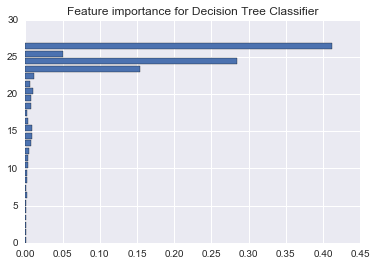

In [54]:
#show graph for feature importance for Decision Tree Classifier 
plt.barh(range(len(feature_imp_ng_dt)), feature_imp_ng_dt)
plt.title("Feature importance for Decision Tree Classifier")
plt.show()

### 2d. Analyze the Results using your chosen method of evaluation

When attempting to predict price level via k-Nearest Neighbors, Random Forest, and Decision Trees, the accuracies were 0.885, 0.884, and 0.976, respectively. When attempting to predict the neighbourhood for the same models, the accuracy levels were 0.785, 0.776, and 0.772, respectively.

The reason why Decision Trees tended to score much higher in terms of accuracy for price level is mostly due to the "pruning" techniques administered as well as other criteria. Basically, with "entropy" as our main criteria and setting out maximum depth to 10, we were able to achieve this level of accuracy. But when using Decision Trees to determine the neighbourhood, the "pruning" needed to not happen nearly as much, with no Maximum Depth required and the criteria to be "gini" instead of entropy. Even with no limit on the maximum number of levels, the Decision Tree was still not as useful as both the KNN or the Random Forest models were.

However, even with the accuracy seen in the first Decision Tree for price, it may make more sense to go with the success of the KNN model for this particular exercise. With only looking at 5 of its nearest records, this model is able to accurately predict the price level 89% of the time with price and 79% of the time for the neighborhood. The way in which this model functions aligns greatly with some of the suggestions that are discussed in the Deployment section of the notebook in regards to how useful this predictive model would be and why.

As with the Random Forest Classifier, even though it also predicted very well, it was slightly less accurate than KNN by 0.05 percentage points for price and nearly 0.1 percentage points for neighbourhood, which is likely not a "Statistically Significant" difference. Since KNN fits better with how we believe this model would work, Random Forest would not be as desirable overall.

### 2e. Discuss the advantages of each model for each task and why?

##### k-Nearest Neighbors
Overall, it makes sense that k-Nearest Neighbors is the model that seems to work the best from an accuracy perspective. The city of New York, specifically the island of Manhattan, is made up of several smaller neighborhoods (31 in Manhattan) with each of these neighborhoods offering their own unique "New York City" quality and feel, from Hell's Kitchen to the Theater District to Harlem to SoHo, just to name a few. With hosts highlighting those qualities within a listing on AirBnB, it's no real surprise that KNN provided the most accurate model, even if just by a couple of percentage points.

For the "price range" prediction, the advantages of using the KNN method to predict price range as well as the number of "neighbors" we chose heavily favors the way in which a site like AirBnB truly operates. Because when determining price range is not purely focused on attributes such as "number of reviews" or "minimum nights", this method is largely looking at attributes such as "room type" and even more importantly the one-hot encoded neighborhood where the listing is located. For example, if we are predicting the price range of a private room in the West Village that is available year-round, our KNN model will look to the 5-nearest neighbors to predict that price range, and because Manhattan is so neighborhood-centric, our model is essentially correct 89% of the time.

When looking at predicting the "neighborhood" of the listing in Manhattan, the accuracy (although not as high as 89%) was still favorable at 78% for the KNN model. Similar to how the model worked when determining the price range, the one-hot encoded attributes of price range were used for this model and essentially worked in the same way, locating the nearest neihgbors sharing those listing's qualities and accurately predicting the correct neighborhood 4 out of 5 times. The accuracy is less for neighborhood most likely because there will always be a listing that for whatever reason is priced unreasonably low or unreasonably high and without the model knowing the context of those listings initially, the accuracy may decrease. In order to increase the accuracy, looking in more detail at the listings that were inaccurately predicted will provide us with more insight and we can go back and tweak future models to take those insights into consideration.

##### Random Forest
It is no surprise that the Random Forest model performed at basically the same level as the KNN model did due to how this model is set up. Not only does the randomness of the samples help with this particular dataset, but it aids in removing any of the bias the data may have underneath. The bias in this case would be how weighted some categories may be compared to others, such as certain neighbourhoods or price ranges as well as the other attributes such as availability and minimum nights. However, even though Random Forest proved to be a good model, it is not necessarily the ideal model in the case of this dataset as discussed above.

##### Decision Tree
Because there is so much customization that goes into running a Decision Tree model, this type of classification is not necessarily ideal with this particular dataset. A Decision Tree, unless otherwise told not to, can continue splitting its classes until there is only one record in a certain node. Even though this is accurate nearly 100% of the time, it doesn't do our any better in the case of predicting neighbourhood.

### 2f. Which attributes from your analysis are most important?

##### Attributes of Predicting Price Range
Because when we one-hot encode all of the neighbourhoods as well as placing each of the prices into one of 50 price bins, the relative importance of these attributes are much less significant in terms of the weight; however, when viewed in aggregate, they are nearly in-line with all of the other attributes used in the model. 

Interestingly enough, the availability and minimum nights seemed to be the most weighted attributes, specifically in the Random Forest model, with Room Type at the aggregate level also being nearly equally as important.

##### Attributes of Predicting Neighbourhood
The primary attributes that seemed to have a higher relative importance were somewhat surprisingly the availability of a listing (i.e. how many days a year is this listing available?) and the number of reviews a listing received. The number of reviews makes more sense than availability does overall because neighbourhoods that may have more listings may also have more reviews in aggregate. Similar to the availability attribute, a majority of listings are available year-round, so this would tend to weigh heavily for those listings which may not be available 365 days a year. 

Additionally, similar to what we observed in predicting price range, the price range at the individual level was extremely small when predicting neighbourhood; however, when added up in aggregate, knowing the price range definitely played a role in helping to determine the neighbourhood.

## 3. Deployment

##### How useful is your model for interested parties?
Just like any hotel or accommodation website that aggregates listings of various places to stay within a city, the competitive landscape is going to be fierce. Because the model(s) are attempting to predict either the price bin/range or the neighbourhood, there are essentially two primary ways to effectively use the models presented. 

First, for consumers of the website, it could be a more accurate representation of "similar listings" that are currenty available per the user's criteria. For example, a listing near Central Park is priced at 166 USD; however, their "similar" listings are not only an average of 1.5 miles away (which is quite the distance in Manhattan), but their respective prices range from 97 USD to 197 USD. Our proposed model would be able to offer listings that are not only closer in proximity but are also closer within the price range of the listing being viewed. The elimination of these variables from a decision-making process allows the consumer to focus on more qualitative attributes, such as the types of restaurants or attractions nearby or even the characteristics of the apartment itself.

Second, the model could lend itself to providing more insights to the hosts who provide listings on AirBnB, thereby ensuring the host that the prices they are setting can be considered competitive based on other listings that have been classified similarly. For example, if a host is creating a listing for a whole apartment in the Tribeca neighborhood of Manhattan and this particular is one of five total listings, the classification model can accurately provide the host with an appropriate price range that listing should fall into. At this point, they can choose to go high or low or stay within the given range for the listing and take their chances on a booking based on that decision.

##### How would you measure the model's value if it was used by these parties?
There are potentially several key performance indicators or KPIs that AirBnB could observe to measure the value of implementing this model based on the two scenarios provided above. 

For the consumer/similar listings usage, AirBnB can perform several A/B Tests on various listings, where the model is used to showcase similar listings vs. a control group that uses the current model to display similar listings. The measure of success in this case would be the "click-through rate" of a user engaging with this particular piece of content, which is simpaly calculated as the total number of pageviews to a certain listing divided by the total number of clicks on a similar listing. This measure can be looked at both from an aggregated as well as a very granular level of detail to better understand how the models affect this KPI for various neighborhoods, room types, etc.

FOr the host/listing price usage, a similar type of KPI can be observed as well. A "booking rate" can be calculated by the number of times a listing was viewed vs. the total number of bookings within a certain time period. The model's effectiveness can be tested by grouping listings that stay within the price range suggested (i.e. "following the model") for a listing vs. those listings that do not follow the guidance of the suggested price range. If the booking rate showed to be successful for ones that followed the model's recommendations, it could be assumed that the reason higher-priced listings did not book as well is because users found similar listings for less and booked them instead, whereas listings that were lower than the suggested price range could have been seen as a listing with possible issues that were not directly addressed in the listing itself, therefore causing users to pay a little more for what is only assumed to be a better apartment in the area because it is only slightly more in overall price.

##### How would your deploy your model for interested parties?
For the consumers of the website, the model could be deployed like any typical algorithm or model is for similar websites. In order to retrieve similar listings, AirBnB would have to analyze a "live dataset" of listings that have the model's predictability applied to it and based on either an accuracy score or precision score, the top 3 listings are sent back to the website to be served up as "similar listings" that share attributes with the listing being viewed.

For the hosts that use AirBnB, a user interface could be created (which is likely already in place) where a host inputs all of the necessary information for a listing to be approved. Within that interface would be a newly-added section that provides a "suggested price range" to the host. At this point, it is up to the host to place their price on the listing, but the model at the least provides the host with useful information and giving insight into what other listings are currently priced at for similar attributes.

##### What other data should be collected?
There wouldn't be too much more that would likely improve the model overall; however, other attributes over time may be looked at as valuable if/when price range and neighborhood is no longer an accurate-enough model. Other attributes that have more to do with room characteristics that can be quantified as well as being able to provide a quantitative value to "nearby" qualities may be useful. For example, being able to state how many restaurants are within 0.5 miles of the listing or the actual distance to the nearest subway station may be useful attributes for a city such as Manhattan. However, if this model were to be more widely used, the model may have to be modified to align with a city's unique traits. For example, in Atlanta, the distance to the nearest MARTA station is basically irrelevant (Atlanta's Mass Transit is horrible); but the distance to specific neighborhoods such as Midtown or Buckhead or the distance to Peachtree Street (the main "street" that runs the length of Atlanta) could be considered more useful to people viewing listings in that city.

##### How often would the model need to be updated, etc.?
According to AirBnB's website where they publish their listing data, the frequency of New York City's listings being udpated is monthly; therefore, it would be recommended to re-train and test the model on a monthly basis. Performing this task at this frequency level may also assist with changes in price ranges due to seasonality and other time-series-based shifts in the data being observed.